In [3]:
import pickle
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
with open("migration_graph.gpickle", "rb") as f:
    G = pickle.load(f)

with open("migration_data.pkl", "rb") as f:
    data = pickle.load(f)
key_nodes_df = data["key_nodes_df"]
edges_df = data["edges_df"]
temporal_changes = data["temporal_changes"]

## Higher Order Properties

In [5]:
# --- Reciprocity ---

# Overall reciprocity of the directed migration graph
overall_recip = nx.reciprocity(G)
print(f"Overall reciprocity: {overall_recip:.3f}")

# Node-level reciprocity for key nodes
node_recip = nx.reciprocity(G, nodes=key_nodes_df['cluster_id'].tolist())
print("\nSample node reciprocity (first 10):")
for nid, r in list(node_recip.items())[:10]:
    print(f"  node {nid}: {r:.3f}" if r is not None else f"  node {nid}: None (isolated)")

# --- Assortativity ---

# Degree assortativity
deg_assort = nx.degree_assortativity_coefficient(G, x='out', y='in', weight='Weight')
print(f"\nDegree assortativity (out-degree vs in-degree, weighted): {deg_assort:.3f}")

Overall reciprocity: 0.004

Sample node reciprocity (first 10):
  node 50: 0.000
  node 140: 0.000
  node 243: 0.000
  node 38: 0.000
  node 119: 0.000
  node 67: 0.000
  node 115: 0.000
  node 51: 0.000
  node 333: 0.000
  node 53: 0.000

Degree assortativity (out-degree vs in-degree, weighted): 0.407


The overal reciprocity of the network is 0.4 % so our migration netowork is mostly one sided.
 Degree assortativity of about 0.41 indicates moderate positive assortativity, so high‑degree stopover hubs tend to connect to other high‑degree hubs, forming a relatively cohesive “core” of heavily used sites

## Temporal Analysis

In [17]:
import pandas as pd
import networkx as nx
import numpy as np
 # For progress tracking

def analyze_evolution_bootstrap(edges_df, cluster_nodes, start_year=2016, n_iterations=100):
    edge_year_flat = edges_df.explode('years').rename(columns={'years': 'year'})
    edge_year_flat = edge_year_flat[edge_year_flat['year'] >= start_year]
    
    yearly_counts = edge_year_flat.groupby('year').size()
    min_edges = yearly_counts.min()
    
    results = []
    all_years = sorted(edge_year_flat['year'].unique())

    for year in all_years:
        year_pool = edge_year_flat[edge_year_flat['year'] == year]
        
        # Lists to store metrics for bootstrap iterations
        it_diameters = []
        it_paths = []
        it_90th_paths = []
        it_lwcc_size = []

        print(f"Bootstrapping Year {year}...")
        for i in range(n_iterations):
            # 1. Bootstrap: Sample with replacement (or without if you prefer rarefaction)
            sub_edges = year_pool.sample(n=min_edges, replace=True)
            
            G = nx.DiGraph()
            G.add_edges_from(zip(sub_edges['source'], sub_edges['target']))
            
            if G.number_of_edges() > 0:
                # 2. Extract LWCC and size
                lwcc_nodes = max(nx.weakly_connected_components(G), key=len)
                lwcc_ratio = len(lwcc_nodes) / cluster_nodes.shape[0]
                it_lwcc_size.append(lwcc_ratio)
                
                # 3. Path calculations (Undirected for diameter/90th)
                subgraph = G.subgraph(lwcc_nodes).copy()
                
                # All shortest path lengths
                path_lengths = []
                spl = dict(nx.all_pairs_shortest_path_length(subgraph))
                for source in spl:
                    for target in spl[source]:
                        if source != target:
                            path_lengths.append(spl[source][target])
                
                if path_lengths:
                    it_diameters.append(max(path_lengths))
                    it_paths.append(np.mean(path_lengths))
                    it_90th_paths.append(np.percentile(path_lengths, 90))
            
        results.append({
            'year': year,
            'diam_mean': np.mean(it_diameters),
            'diam_std': np.std(it_diameters),
            'path_mean': np.mean(it_paths),
            'path_std': np.std(it_paths),
            'path_90th_mean': np.mean(it_90th_paths),
            'lwcc_size_mean': np.mean(it_lwcc_size)
        })

    return pd.DataFrame(results)

bootstrap_df = analyze_evolution_bootstrap(edges_df, key_nodes_df)
print(bootstrap_df)

Bootstrapping Year 2016...
Bootstrapping Year 2017...
Bootstrapping Year 2018...
Bootstrapping Year 2019...
Bootstrapping Year 2020...
Bootstrapping Year 2021...
Bootstrapping Year 2022...
Bootstrapping Year 2023...
Bootstrapping Year 2024...
Bootstrapping Year 2025...
   year  diam_mean  diam_std  path_mean  path_std  path_90th_mean  \
0  2016       4.69  1.083467   2.230000  0.361156           3.691   
1  2017       4.59  1.312212   2.196667  0.437404           3.621   
2  2018       4.38  1.247237   2.126667  0.415746           3.466   
3  2019       4.17  0.679043   2.056667  0.226348           3.301   
4  2020       4.92  1.547126   2.306667  0.515709           3.899   
5  2021       4.97  1.615271   2.323333  0.538424           3.917   
6  2022       4.54  1.195157   2.180000  0.398386           3.617   
7  2023       4.92  1.293677   2.306667  0.431226           3.917   
8  2024       4.47  1.152866   2.156667  0.384289           3.583   
9  2025       4.46  1.211776   2.153333 

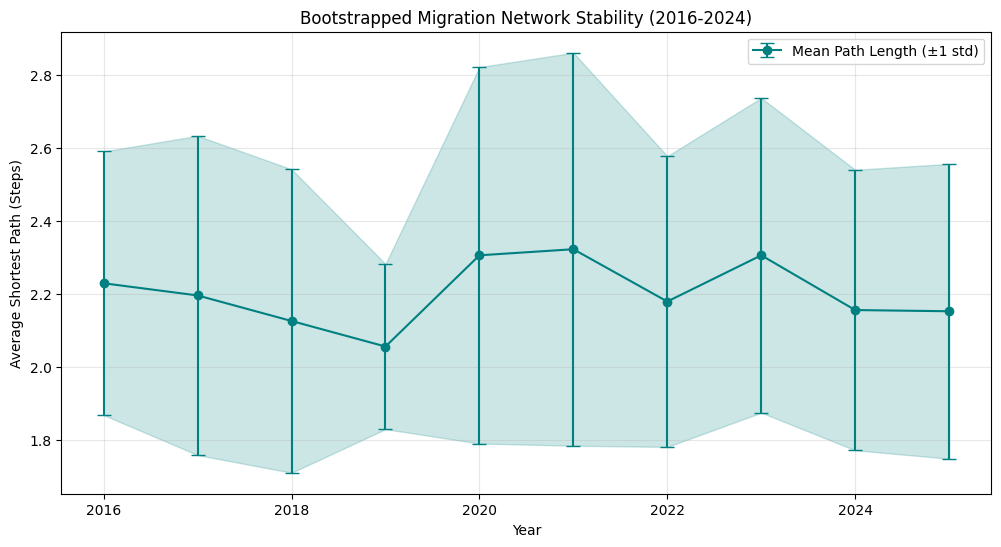

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotting Path Mean with Standard Deviation as a shaded area
plt.errorbar(bootstrap_df['year'], bootstrap_df['path_mean'], 
             yerr=bootstrap_df['path_std'], fmt='-o', capsize=5, 
             label='Mean Path Length (±1 std)', color='teal')

plt.fill_between(bootstrap_df['year'], 
                 bootstrap_df['path_mean'] - bootstrap_df['path_std'],
                 bootstrap_df['path_mean'] + bootstrap_df['path_std'], 
                 alpha=0.2, color='teal')

plt.title('Bootstrapped Migration Network Stability (2016-2024)')
plt.xlabel('Year')
plt.ylabel('Average Shortest Path (Steps)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

To avoid getting biased results (due to different sampling effort across years), we normalize each year by the number of edges (we use the same number of edges each year). Differences in diameter/path length are not trivially driven by edge count.
We use LWCC (Largest Weakly Connected Component), this allows to distinguish true-path-length changes vs. network fragmentation or contraction. 
We use the 90th percentile path length instead of only diameter. 
We conduct 100 iterations to compute the latter metrics to overcome noise and outliers coming from randomness. Metrics are shown as the mean over the 100 iterations. 

Results and Interpretation

Strong Overall Stability
- **Mean path length:** 2.05–2.32 steps  
- **90th percentile path length:** 3.30–3.92 steps  
- **Diameter:** 4.2–5.0 steps  

This indicates:
- No progressive fragmentation of the network  
- No systematic elongation of migration routes  
- No collapse or expansion of reachability  

Overall, the **structural depth of the migration network is highly stable** across the study period.

Temporary Disruption (2020–2021)
- Migration paths became temporarily longer  
- Increased variability in path lengths  

From **2022 onward**, path lengths return to the historical range, indicating recovery rather than a lasting structural change.




## Degree Distribution

,year,num_nodes,num_edges,avg_in_degree,max_in_degree,walks_len_2,walks_len_3
0,2015,57,37,0.649123,1.0,17.0,9.0
1,2016,438,251,0.573059,1.0,64.0,33.0
2,2017,464,268,0.577586,1.0,72.0,39.0
3,2018,488,278,0.569672,1.0,68.0,33.0
4,2019,463,263,0.568035,1.0,63.0,27.0
5,2020,482,269,0.558091,1.0,56.0,30.0
6,2021,502,291,0.579681,1.0,80.0,44.0
7,2022,505,287,0.568317,1.0,69.0,33.0
8,2023,521,299,0.573896,1.0,77.0,49.0
9,2024,503,280,0.556660,1.0,57.0,28.0


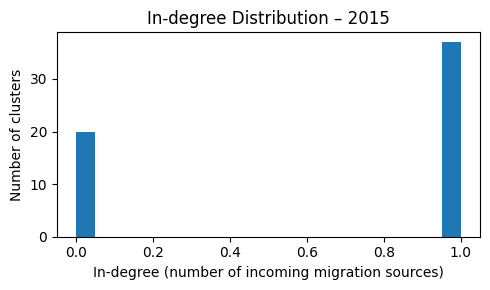

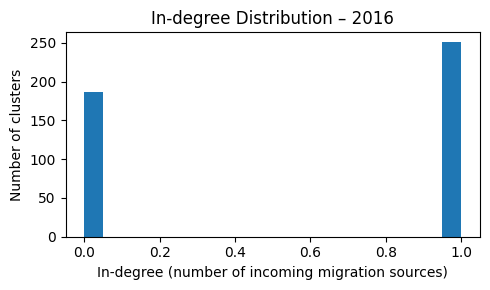

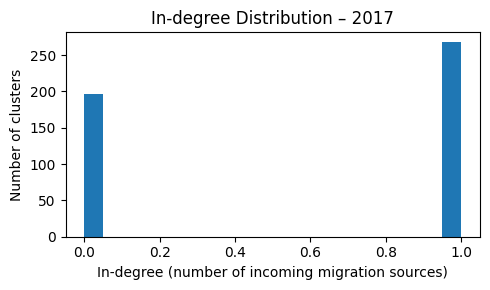

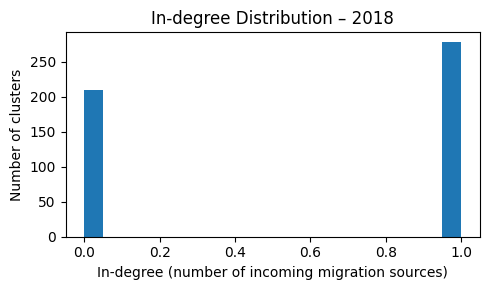

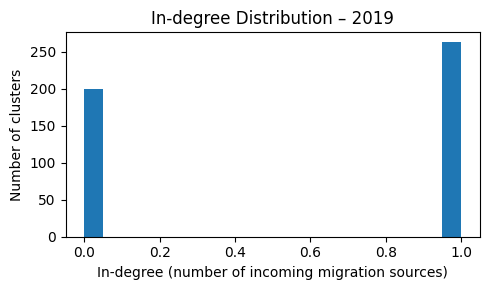

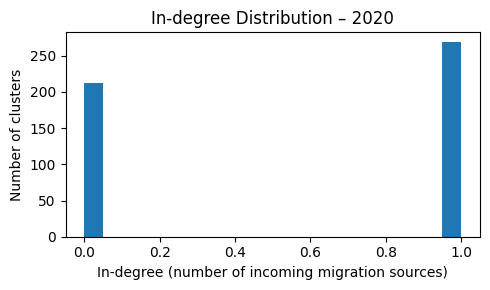

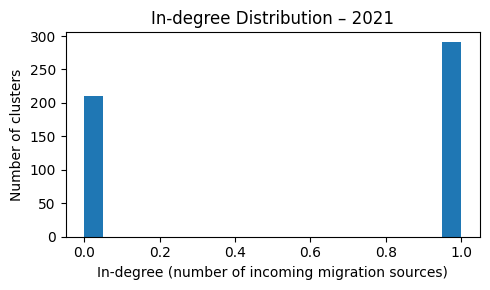

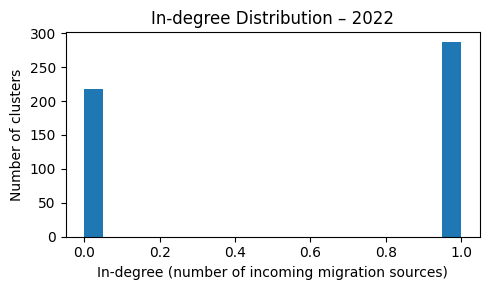

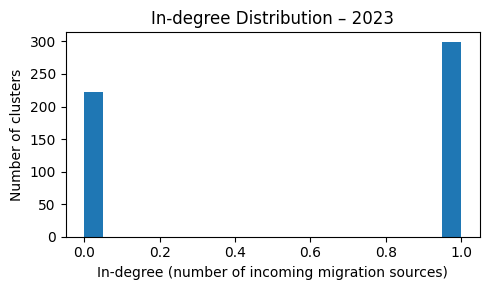

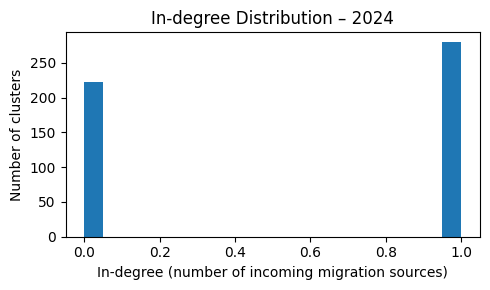

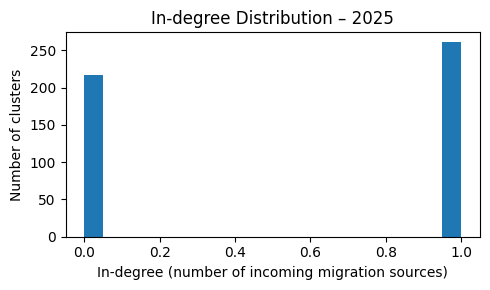

In [11]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expand edges so that each row corresponds to one edge in one year
edges_exploded = edges_df.explode('years')
edges_exploded['years'] = edges_exploded['years'].astype(int)

# Store results across years
results = []
in_degree_distributions = {}

# Analyze the migration network year by year
for year in sorted(edges_exploded['years'].unique()):

    # Keep only edges active in the current year
    year_edges = edges_exploded[edges_exploded['years'] == year]

    # Build a directed migration graph
    G_year = nx.DiGraph()
    for _, row in year_edges.iterrows():
        G_year.add_edge(
            row['source'],
            row['target'],
            weight=row['weight'] if 'weight' in year_edges.columns else 1
        )

    if G_year.number_of_nodes() == 0:
        continue

    # Create adjacency matrix (binary: migration exists or not)
    # A[i, j] = 1 if birds migrate from cluster i to cluster j
    A = nx.to_numpy_array(G_year, weight=None)

    # In-degree is the column sum of the adjacency matrix
    # This shows how many migration sources feed into each cluster
    in_degree = A.sum(axis=0)
    in_degree_distributions[year] = in_degree

    # Count walks using matrix powers
    # A^2 counts 2-step migration paths (via one intermediate cluster)
    # A^3 counts 3-step migration paths
    A2 = np.linalg.matrix_power(A, 2)
    A3 = np.linalg.matrix_power(A, 3)

    total_walks_len_2 = A2.sum()
    total_walks_len_3 = A3.sum()

    # Store summary metrics for comparison across years
    results.append({
        'year': year,
        'num_nodes': G_year.number_of_nodes(),
        'num_edges': G_year.number_of_edges(),
        'avg_in_degree': in_degree.mean(),
        'max_in_degree': in_degree.max(),
        'walks_len_2': total_walks_len_2,
        'walks_len_3': total_walks_len_3
    })

# Show how the network evolves over time
results_df = pd.DataFrame(results).sort_values('year')
display(results_df)

# Plot in-degree distributions to identify migration hubs
for year, in_degree in in_degree_distributions.items():
    plt.figure(figsize=(5, 3))
    plt.hist(in_degree, bins=20)
    plt.xlabel("In-degree (number of incoming migration sources)")
    plt.ylabel("Number of clusters")
    plt.title(f"In-degree Distribution – {year}")
    plt.tight_layout()
    plt.show()


No cluster ever receives birds from more than one other cluster in a single year. The network behaves like chains. So, we can't find hubs in our network. 

In [12]:
# Normalize walk counts by network size (number of nodes)
results_df['norm_walks_len_2'] = results_df['walks_len_2'] / results_df['num_nodes']
results_df['norm_walks_len_3'] = results_df['walks_len_3'] / results_df['num_nodes']

display(results_df[['year', 'norm_walks_len_2', 'norm_walks_len_3']])


,year,norm_walks_len_2,norm_walks_len_3
0,2015,0.298246,0.157895
1,2016,0.146119,0.075342
2,2017,0.155172,0.084052
3,2018,0.139344,0.067623
4,2019,0.136069,0.058315
5,2020,0.116183,0.062241
6,2021,0.159363,0.087649
7,2022,0.136634,0.065347
8,2023,0.147793,0.094050
9,2024,0.113320,0.055666


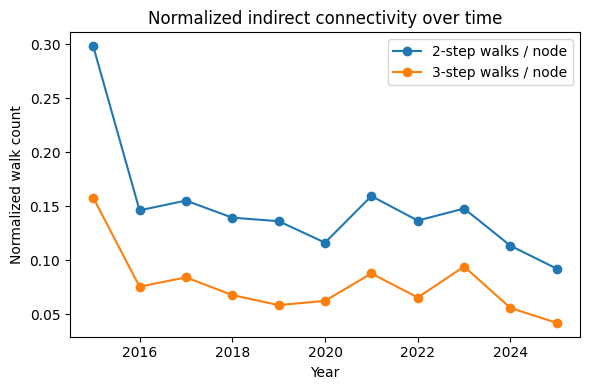

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(results_df['year'], results_df['norm_walks_len_2'], marker='o', label='2-step walks / node')
plt.plot(results_df['year'], results_df['norm_walks_len_3'], marker='o', label='3-step walks / node')
plt.xlabel("Year")
plt.ylabel("Normalized walk count")
plt.title("Normalized indirect connectivity over time")
plt.legend()
plt.tight_layout()
plt.show()


### Normalized indirect connectivity over time

Indirect connectivity remains relatively stable between 2016 and 2020. There are peaks in 2021 to 2023. Since node degrees have a maximum value of one, these increases cannot be attributed to local branching or hub formation. Instead, they indicate a higher presence of uninterrupted multi-step migration chains, suggesting increased global alignment of migration routes during this period. The decline after 2023 reflects reduced continuity of such chains or incomplete data coverage in recent years.
